PROYECTO DE FORECAST:

The data: The M5 Competition

Abstract

Forecasting, the prediction of future events from past data, is central to decision-making in virtually all technical domains. For instance, predicting product sales in retail, forecasting energy demand, or anticipating customer churn, all have tremendous value across different industries. However, the landscape of forecasting techniques is as diverse as it is useful, and different techniques and expertise are adapted to different types and sizes of data.

In this hands-on workshop led by experts from Tryolabs and Google, we give an overview of forecasting concepts, methods, and practical applications on the M5 forecasting challenge. In the context of forecasting, we’ll walk you through the data exploration, data preparation, feature engineering, statistical (e.g., STL, ARIMA) and machine learning (e.g., decision forests) modeling, meta-modeling (e.g., hierarchical and relational modeling, ensembles, resource models), and how to safely evaluate such temporal models.

We conclude the session with a discussion and a list of reading materials to learn more about forecasting. Join us for a fun and interactive workshop hosted by Tryolabs and Google!

Agenda:

Intro to forecasting
- M5 dataset
- Evaluation metric

Modeling
- Baseline
- SARIMA
- Tabular with GBDT

Feature engineering
- Calendar features
- Moving statistics
- Special events

Further resources
Conclusions

INSTALL DEPENDECIES

In [85]:
# #@title Install dependencies

# %%shell
# pip install -U -q pandas
# pip install -U -q matplotlib
# pip install -U -q seaborn
# pip install -U -q statsmodels
# pip install -U -q tensorflow_decision_forests
# apt-get -qq install -y graphviz && pip install pydot

In [86]:
#GET DATA:
#@title
# download and unzip data
# %%shell
# wget -q -O data.zip 'https://docs.google.com/uc?export=download&id=1NYHXmgrcXg50zR4CVWPPntHx9vvU5jbM&confirm=t'
# unzip -o data.zip


IMPORT PACKAGES

In [87]:
#Import packages

import gc
import re
from collections import defaultdict
from typing import Tuple, Optional, List, NamedTuple, Union

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import tensorflow_decision_forests as tfdf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm
import pydot
from IPython.display import Image

plt.style.use("default")
plt.rcParams["figure.figsize"] = (12, 3)

Intro to Forecasting

Forecasting is a crucial aspect of many industries and fields, including finance, healthcare, manufacturing, and transportation. It helps organizations make informed decisions by anticipating future trends and outcomes, which can improve efficiency and reduce costs.

With this technique, we can predict future events from past data and existing knowledge. Following are example of forecasting problems:

- Forecast next year's sales
- Forecast stocks price
- Forecast energy demand
- Forecast next week's weather
- Forecast the onset of cancer
- Forecast the score of a soccer match
- Forecast the propability of customer churn

A forecast is the source of knowledge that makes planning and decision-making possible. For example:

- Forecasting the weather at sea to plan the ship's routes, and save on fuel and maintenance.
- Forecasting next year's sales for a car manufacturer to plan for electronic component purchases.
- Forecasting the onset of cancer allows for early treatment and a higher chance of recovery.

## How to forecast?

The landscape of forecasting techniques is as diverse as it is useful. Different techniques exist for different types (e.g., time sequences, time series, transactions) and amounts (e.g., 10 observations, 10B observations) of data, as well as for different type of predictions.

On small time series dataset, statistical models such as [ARIMA](https://otexts.com/fpp3/arima.html) and [Exponential Smoothing](https://otexts.com/fpp3/expsmooth.html) are well suited. On larger datasets where more complex models can be learned, deep learning and [decision forests](https://en.wikipedia.org/wiki/Random_forest) methods are commonly used. In this session, we will demonstrate the use of one statistical model (ARIMA) and a more powerful general purpose model (decision forests).

Data-preparation plays an important role in forecasting. Feature engineering is useful to inject expert knowledge in models when only a small amount of data is available.

For example, [heart rate variability](https://en.wikipedia.org/wiki/Heart_rate_variability) is predictive of some cardiac events. If operating on electrocardiogram data, pre-computing the heart rate variability is beneficial for many forecasting tasks.

Feature engineering is also important on large datasets. It is used to extend the power of expression of forecasting models. For example, while a [feed-forward neural network](https://en.wikipedia.org/wiki/Feedforward_neural_network) is not able to consume [relational data](https://en.wikipedia.org/wiki/Relational_database), preprocessing (called "flattening" in this case) relational data into tabular data can be beneficial for the modeling task.

In this session, we will demonstrate several feature engineering methods for forecasting.


## Forecasting on Timeseries

Let's start simple. A (univariate) time series (TS) is a sequence of numerical values sampled at a constant rate (e.g., once a day). The only variable is the time, often represented by 𝑡.

A TS can be represented as a plot where the horizontal axis is the time, and the vertical axis is the TS value.

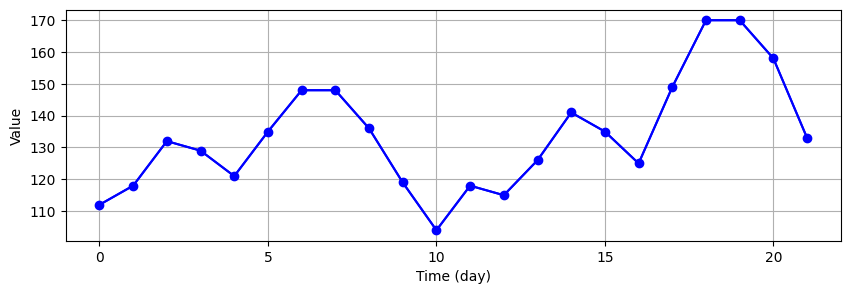

In [88]:
#@title Univariate time series
values = [
    112,
    118,
    132,
    129,
    121,
    135,
    148,
    148,
    136,
    119,
    104,
    118,
    115,
    126,
    141,
    135,
    125,
    149,
    170,
    170,
    158,
    133
]

plot_xlim = [-1, len(values)]

plt.figure(figsize=(10, 3))
plt.plot(values, color="blue")
plt.plot(values, marker="o", color="blue")
plt.xlabel("Time (day)")
plt.ylabel("Value")
plt.xlim(plot_xlim)
plt.grid()
plt.show()

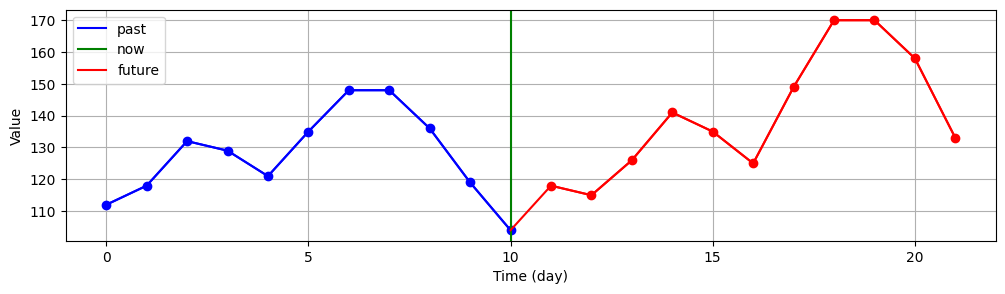

In [89]:
#@title Forecast
past_data = [112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104]
past_time = [i for i in range(len(past_data))]
now_time = len(past_time) - 1
future_data = [118, 115, 126, 141, 135, 125, 149, 170, 170, 158, 133]
future_time = [i + len(past_time) for i in range(len(future_data))]

plot_xlim = [-1, future_time[-1] + 1]


plt.plot(past_time, past_data, color="blue", label="past")
plt.plot(past_time, past_data, color="blue", marker="o")
plt.axvline(x=now_time, color="green", label="now")
plt.plot(future_time, future_data, color="red", marker="o")
# add last past value in order to join future and past line
plt.plot([past_time[-1]] + future_time, [past_data[-1]] + future_data, color="red", label="future")


plt.xlabel("Time (day)")
plt.ylabel("Value")
plt.xlim(plot_xlim)
plt.legend()
plt.grid()
plt.show()

The prediction can be a single point such as the expected value, a distribution, or a statistic of this distribution (e.g. first quantile). It is common to predict both the expected value and the confidence boundaries on the prediction.

**Example of next-step forecast:** How much product will be solved tomorow?

### Multi-steps forecast

More complex is the forecasting of the next $h>1$ steps: $\{ s[t+i]\ |\ i \in [1, h] \}$

*Note: $h$ stands for "horizon".*

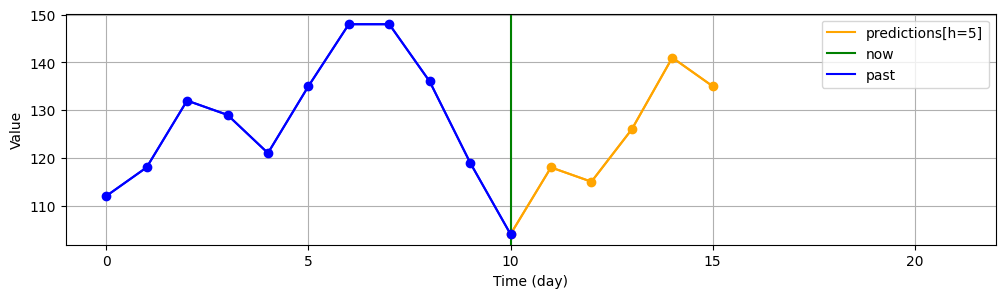

In [90]:
#@title
#adding last past data point to draw line between past data and prediction
predictions = [past_data[-1]] + future_data[:5]
predictions_time = [past_time[-1]] + future_time[:5]

plt.plot(predictions_time, predictions, color="orange", label="predictions[h=5]")
plt.plot(predictions_time, predictions, color="orange", marker="o")
plt.axvline(x=now_time, color="green", label="now")
plt.plot(past_time, past_data, color="blue", label="past")
plt.plot(past_time, past_data, color="blue", marker="o")

plt.xlabel("Time (day)")
plt.ylabel("Value")
plt.xlim(plot_xlim)
plt.legend()
plt.grid()
plt.show()

### Aggregated forecast

In some cases, predicting the aggregated values of the next steps is easier and equally useful for planning.

For example, we can predict the sum or the maximum of the TS in the next h days:
$$
\sum_{i=1}^h s[t+i]
$$
or
$$
\max_{i \in [1, h]} s[t+i]
$$

**Concrete example:** predict the sum of sales in the next 28 days.




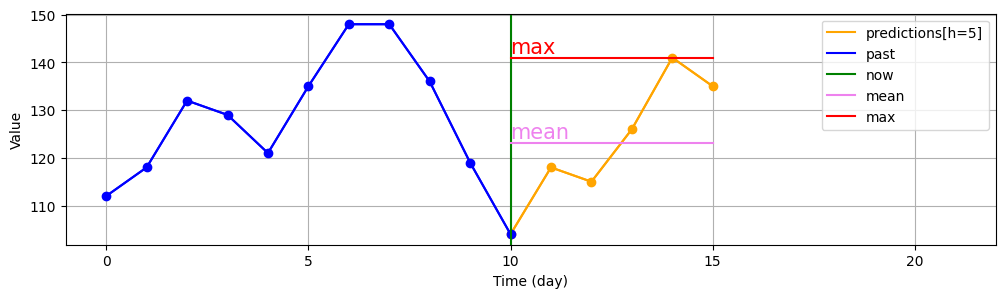

In [91]:
#@title
# calculate mean and max of predictions
mean = np.mean(predictions)
max = np.max(predictions)

plt.plot(predictions_time, predictions, color="orange", label="predictions[h=5]")
plt.plot(predictions_time, predictions, color="orange", marker="o")
plt.plot(past_time, past_data, color="blue", label="past")
plt.plot(past_time, past_data, color="blue", marker="o")
plt.axvline(x=now_time, color="green", label="now")

# plot mean and max in predictions time
plt.plot(
    predictions_time, [mean] * len(predictions_time), color="violet", label="mean"
)

# ADD mean title above the mean line
plt.text(
    predictions_time[0],
    mean + 1,
    "mean",
    fontsize=15,
    color="violet",
)

plt.plot(predictions_time, [max] * len(predictions_time), color="red", label="max")

# ADD max title above the max line
plt.text(
    predictions_time[0],
    max + 1,
    "max",
    fontsize=15,
    color="red",
)

plt.xlabel("Time (day)")
plt.ylabel("Value")
plt.xlim(plot_xlim)
plt.legend()
plt.grid()
plt.show()

### Conditional forecast

Finally, it is sometimes enough to only predict a condition on the data. For example, we can predict if the value will be greater than a threshold $\tau$ in the next $h$ steps: $\ s[t+i] \ge \tau$ for $i \in [1,h]\ $.

**Concrete example:** Will the heart rate of the patient go under 5 beats per seconds in the next 6h.

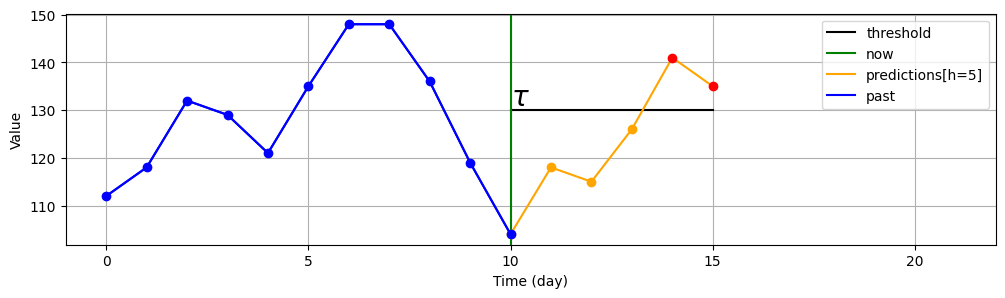

In [92]:
#@title
tau = 130

plt.text(
    predictions_time[0],
    tau + 1,
    r"$\tau$",
    fontsize=20,
    color="black",
)

# draw horizontal line in tau in predictions time
plt.plot(
    predictions_time,
    [tau] * len(predictions_time),
    color="black",
    label="threshold",
)

plt.axvline(x=now_time, color="green", label="now")

# highlight predictions above tau

plt.plot(predictions_time, predictions, color="orange", label="predictions[h=5]")
for i in range(len(predictions)):
    if predictions[i] > tau:
        plt.plot(
            predictions_time[i],
            predictions[i],
            color="red",
            marker="o",
        )
    else:
        plt.plot(
            predictions_time[i],
            predictions[i],
            color="orange",
            marker="o",
        )

plt.plot(past_time, past_data, color="blue", label="past")
plt.plot(past_time, past_data, color="blue", marker="o")

plt.xlabel("Time (day)")
plt.ylabel("Value")
plt.xlim(plot_xlim)
plt.legend()
plt.grid()
plt.show()

**Note:** The prediction of aggregated and condition forecasting can be computed from multi-step forecasting predictions. However, multi-step forecasting can require more data and more complex modeling than aggregated/conditional forecasting. In such a case, forecasting aggregate/conditional forecasting directly can be more efficient.

# Execution mode

For faster iteration during this codecamp, we make available three `EXECUTION_MODE`s that control the speed and quality of some of the computation. The available modes are:

- `EXECUTION_MODE="TOY"`: Very fast execution, poor results.
- `EXECUTION_MODE="MINI"`: Fast execution, cells run in 3 minutes maximum, decent results. We will be using this mode during this codecamp.
- `EXECUTION_MODE="FULL"`: Slow execution, best results. We make this mode available for attendees that want to give it a go at home.


In [93]:
EXECUTION_MODE = "MINI"
# Here you can see the available config and their parameter values.
#
# num_trees: Number of decision trees trained in each model.
# num_items / num_stores: Number of selected items /stores in the dataset.
# num_horizons: How many steps to forecast in multi-step forecast.

available_configs = {
    "TOY": {
        "num_trees": 20,
        "num_items": 3,
        "num_stores": 3,
        "num_horizons": 2,
    },
    "MINI": {
        "num_trees": 75,
        "num_items": 5,
        "num_stores": 5,
        "num_horizons": 7,
    },
    "FULL": {
        "num_trees": 1000,
        "num_items": None,
        "num_stores": None,
        "num_horizons": 28,
    }
}

config = available_configs[EXECUTION_MODE]
print(f"{config=}")

config={'num_trees': 75, 'num_items': 5, 'num_stores': 5, 'num_horizons': 7}


# The data: The M5 Competition

The [M5 Competition](https://www.kaggle.com/competitions/m5-forecasting-accuracy/overview) is the 2020 instance of the [Makridakis Forecasting Competitions](https://en.wikipedia.org/wiki/Makridakis_Competitions). The objective of this competition is to forecast the next 28 days of sales of 3k individual items in 10 different Walmart stores.

Walmart's data possesses a strong hierarchical structure, since each item belongs to a certain category and department, and each store to a certain state.

This means that, besides the 30k individual low-level time series corresponding to the daily sales of a specific item in a specific store (which we'll be referring to as an "item-store" or "level 12" time series), the data can be aggregated in multiple ways to generate a total of 42,840 time series to be forecasted, as shown in the images below.

In this notebook, we will stick to only predicting the sales of item-store series, though the data's hierarchical structure will come in handy in the feature engineering stage.

Details such as the [competition's guide](https://github.com/Mcompetitions/M5-methods/blob/master/M5-Competitors-Guide.pdf) and [Makridakis' analysis of the winning entries](https://www.researchgate.net/publication/344487258_The_M5_Accuracy_competition_Results_findings_and_conclusions) are available online.

<img src="https://drive.google.com/uc?export=view&id=1ssPXZf1uVtNnbbjaaEEqpx4ZmhQobmSE" width=800/>
<img src="https://drive.google.com/uc?export=view&id=1jBT0pPcSWf8n5bJkZ1G7y_glrQcrYKoI" width=800/>

Source: [The M5 Accuracy competition: Results, findings and conclusions](https://www.researchgate.net/publication/344487258_The_M5_Accuracy_competition_Results_findings_and_conclusions)

## Load the dataset

Let's download and unzip the competition's dataset.

In [94]:
# #@title
# # download and unzip data
# %%shell
# wget -q -O data.zip 'https://docs.google.com/uc?export=download&id=1NYHXmgrcXg50zR4CVWPPntHx9vvU5jbM&confirm=t'
# unzip -o data.zip

The dataset is composed of 5 csv files:

- `sales_train_evaluation`: The history of item sales.
- `calendar.csv`: Dates and calendar events related to the sales.
- `sell_prices.csv`: The history of the item prices. **Not used in this codecamp.**
- `sales_train_validation`: Another set of sales. **Not used in this codecamp.**
- `sample_submission`: An example of submission for the competition. **Not used in this codecamp.**


Following are the column names used in the dataset. To minimize errors, we recommend using these variables.

In [95]:
# Identifier of a sales timeseries.
# This is the series of sales values of a given ITEM, in a given STORE.
ID = "id"

ITEM = "item_id" # Identifier of the item
STORE = "store_id" # Identifier of the store
DEPT = "dept_id" # Identifier of the item's department
CAT = "cat_id" # Identifier of the item's category
STATE = "state_id" # Identifier of the store's state

DAY = "d" # Identifier of the day, sequential number from day 1 to 1941
DATE = "date" # The calendar date each day corresponds to
SALES = "sales" # The sales value for an ID on a certain DAY
PRED = "sales_pred" # The predicted sales value for an ID on a certain DAY

Let's load and take a look at the historical sales in  `sales_train_evaluation.csv`. Each row contains the sales of a item+store pair (i.e. for a given item in a given store). Sales are aggregated per day. Each day, indexed between 1 and 1914 (5+ years), is stored in a different column.

**Note:** Most of the values in this dataset are strings (e.g. stores are `CA_1`, `CA_2`, ...) with few unique values. To limit the memory footprint, we will load those columns as [Pandas' categorical dtype](https://pandas.pydata.org/docs/user_guide/categorical.html).

In [96]:
# load sales data
raw_sales = pd.read_csv(
    r'C:\Users\andre\Desktop\Scripts\DATASETS\CSV\m5-forecasting-accuracy\sales_train_evaluation.csv',
    dtype={
        ID: "category",
        ITEM: "category",
        DEPT: "category",
        CAT: "category",
        STORE: "category",
        STATE: "category",
    }
)

# print the memory footprint of the dataset
print("Memory usage")
print(raw_sales.info())

# print the first 5 rows i.e. the first 5 item & store entries
print("First 5 rows")
raw_sales.head()

Memory usage
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: category(6), int64(1941)
memory usage: 453.1 MB
None
First 5 rows


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [97]:

# # Identifier of a sales timeseries.
# # This is the series of sales values of a given ITEM, in a given STORE.
# ID = "id"

# ITEM = "item_id" # Identifier of the item
# STORE = "store_id" # Identifier of the store
# DEPT = "dept_id" # Identifier of the item's department
# CAT = "cat_id" # Identifier of the item's category
# STATE = "state_id" # Identifier of the store's state

# DAY = "d" # Identifier of the day, sequential number from day 1 to 1941
# DATE = "date" # The calendar date each day corresponds to
# SALES = "sales" # The sales value for an ID on a certain DAY
# PRED = "sales_pred" # The predicted sales value for an ID on a certain DAY

# # load sales data
# raw_sales = pd.read_csv(
#     r'C:\Users\andre\Desktop\Scripts\DATASETS\CSV\m5-forecasting-accuracy\sales_train_evaluation.csv',
#     encoding ='latin1',
#     engine ="python",
#     sep =',',
#     on_bad_lines ='skip',
#     dtype={
#         ID: "category",
#         ITEM: "category",
#         DEPT: "category",
#         CAT: "category",
#         STORE: "category",
#         STATE: "category",
#     }
# )

# # print the memory footprint of the dataset
# print("Memory usage")
# print(raw_sales.info())

# # print the first 5 rows i.e. the first 5 item & store entries
# print("First 5 rows")
# raw_sales.head()

##  Explore the dataset

Looking at the data is the first step of any forecasting exercise. Although we won't do a thorough exploratory data analysis in this codecamp, lets take a quick look at some plots to get a grasp on the data we're dealing with.

Let's plot the first three series:

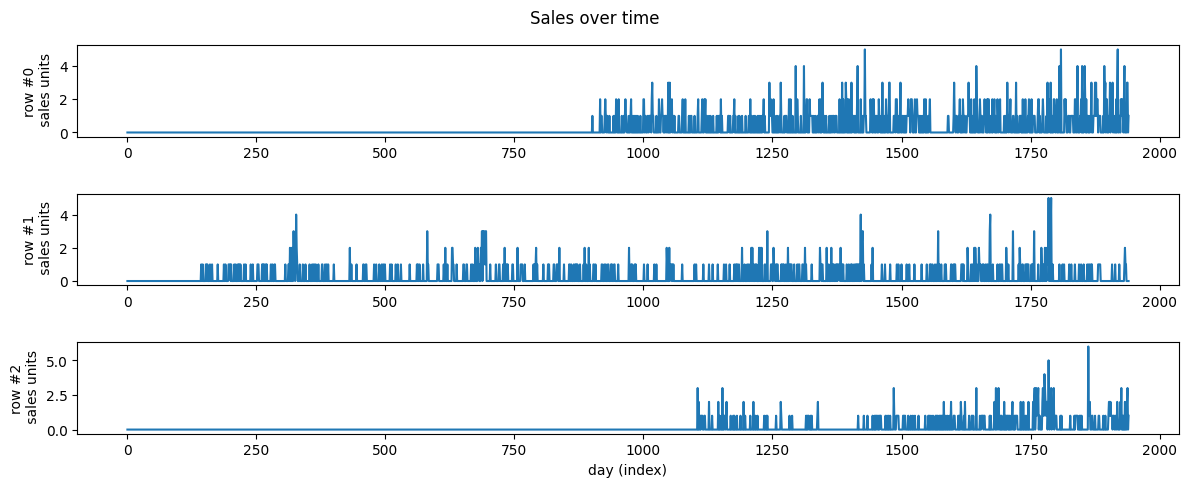

In [98]:
#@title
num_plots = 3
plt.figure(figsize=(12,2 * num_plots))

d_cols = list(raw_sales.filter(regex="d_"))

for row_idx in range(num_plots):
  # "ts" refers to "timeseries".
  sales_ts = raw_sales.iloc[row_idx][d_cols].to_numpy()

  plt.subplot(num_plots+1, 1, row_idx+1)
  plt.plot(sales_ts)
  plt.ylabel(f"row #{row_idx}\n sales units")

plt.suptitle("Sales over time")
plt.xlabel("day (index)")
plt.tight_layout(h_pad=1)
plt.show()

### Question

1. What insights or conclusions do you draw from the plots above?

In [99]:
#@title Solution

# 1. Not all products started being sold at the same time. They usually start with 0 sales units.
# 2. Row #0, #1 and #3 show really different pattern. Row #0 and #2 look quite irregular. Row #1 shows some peaks every 365 days approx.
# 3. Row #2 show a period, which seems to be an out-of-stock period, between day 1250 and 1500.
# 4. Sales seem very sporadic for row #1, with several periods of 0 sales.
# 5. any others?

Let's do a zoom in on the last 28 days for a single item:

<Axes: title={'center': 'HOBBIES_1_001_CA_1_evaluation'}>

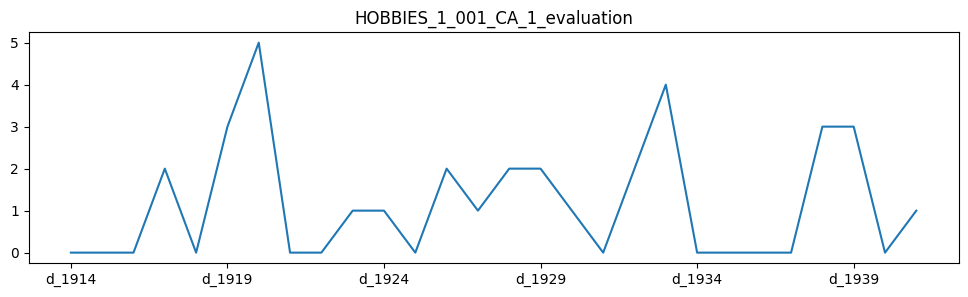

In [100]:
example_id = "HOBBIES_1_001_CA_1_evaluation"
d_cols = list(raw_sales.filter(regex="d_"))

# select the sales of our example item
example_ts = raw_sales[(raw_sales[ID] == example_id)][d_cols].squeeze()

# plot the last 28 days of sales.
example_ts[-28:].plot.line(title=example_id)

At the item-store level, sales can be very sparse for non popular items. For example, in the plot above, there were no sales in about half the displayed days.

It can be interesting to look at aggregated sales according to different dimensions. For example, the following plot shows the sales for the store `CA_1`, once you've completed the exercise of filling the code for `aggregate_sales_by_store`.

### Exercise

In [101]:
# def aggregate_sales_by_store(sales : pd.DataFrame) -> pd.DataFrame:
#   """ Aggregate the sales units by store."""

#   # TODO: add your code here #
#   # Hint: What aggregation function would you use for sales units?

#   return sales_by_store

<Axes: >

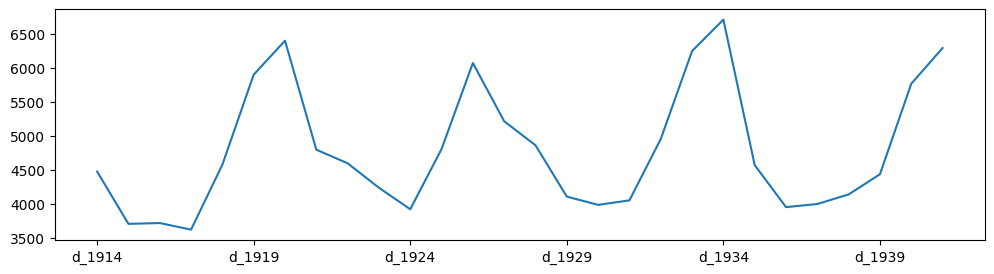

In [102]:
def aggregate_sales_by_store(sales):
  """ Aggregate the sales units by store. """

  sales_by_store = (
      raw_sales
      .groupby([STORE])
      .agg("sum", numeric_only=True)
      .reset_index()
  )

  return sales_by_store

# plot the last 28 days of sales of the store CA_1
sales_by_store = aggregate_sales_by_store(raw_sales)
sales_by_store[sales_by_store[STORE] == "CA_1"][d_cols].squeeze()[-28:].plot.line(x=DATE, y=SALES)

As we can see, the store level time series follows a much stronger and steadier pattern that the item-store level ones - and would therefore be much easier to forecast.

Lets take a look at the number of average daily sales for each ID.

<Axes: >

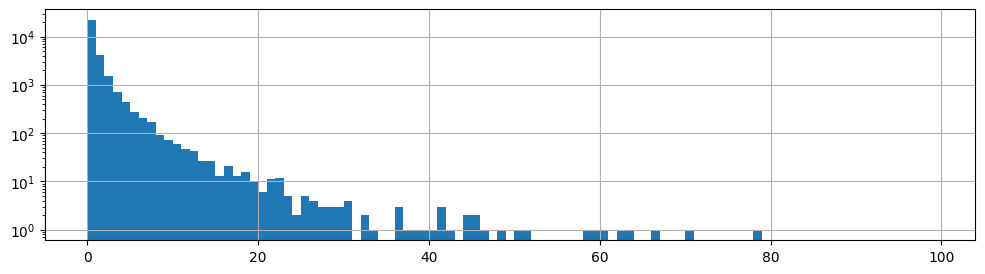

In [103]:
# plot histogram of item/store average daily sales
raw_sales[d_cols].mean(axis=1).squeeze().hist(log=True, bins=range(100))

## Trend and Seasonality

**Trend**: direction or tendency of the time series during a long period of time.

**Seasonality**: patterns or variations that repeat at a regular interval.

This dataset is about sales made by people, and usually, human behavior exhibits cycles. The most notables interval of these cycles are 1 day, 1 week, 1 month, and 1 year.

The next plot shows the **sum of all the sales over the last 2 months**. At this scale, the 7 days seasonality is very clear.

<Axes: >

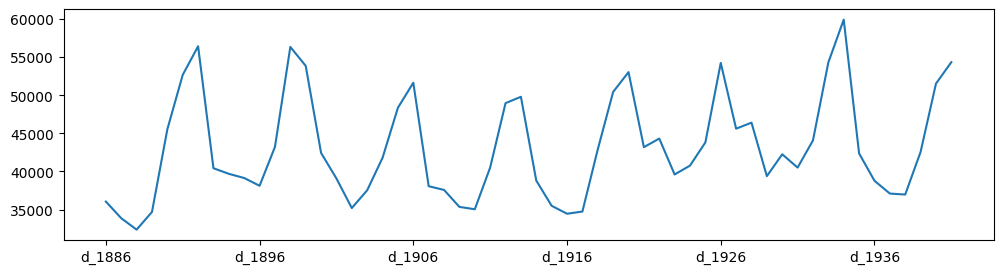

In [104]:
#@title
# plot the sum of all the sales over the last 2 months.
sales_global = raw_sales[d_cols].sum(axis=0).squeeze()
sales_global[-56:].plot.line()

Now, if we zoom-out and plot sales over the last 5 years, the 7 days seasonality is visible but hard to see because its very compressed.

<Axes: >

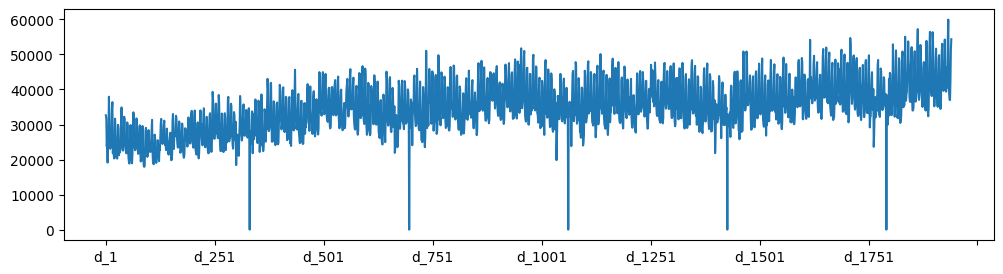

In [105]:
# plot the daily global sum of sales
sales_global.plot.line()

We can also see both some kind of yearly seasonality, and a global upwards trend.

For example in 2011, the daily sales were around 25k, while they are around 45k in 2016. An easier way to visualize these yearly patterns is to apply a moving average on the time series (i.e., swapping each datapoint in the series for the average of a fixed amount of datapoints around it).

<Axes: >

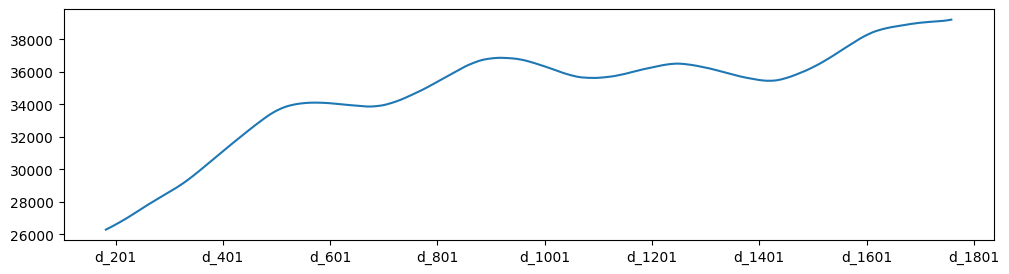

In [106]:
sales_global.rolling(365, center=True, win_type="triang").mean().plot.line()

We can see that sales are globally increased during those 5 years. Keep in mind though that, as we saw before, some products started being sold much later than `d_1`, so this global upwards trend doesn't necessarily indicate a similar trend in the item-store level time series.

Instead of trying to visualize these components of our time series manually, we could use a method such as **STL descomposition** (Seasonal and Trend decomposition using Loess), which decomposes a times series into trend, seasonal, and residual components.

More information about STL can be found [here](https://otexts.com/fpp3/stl.html).

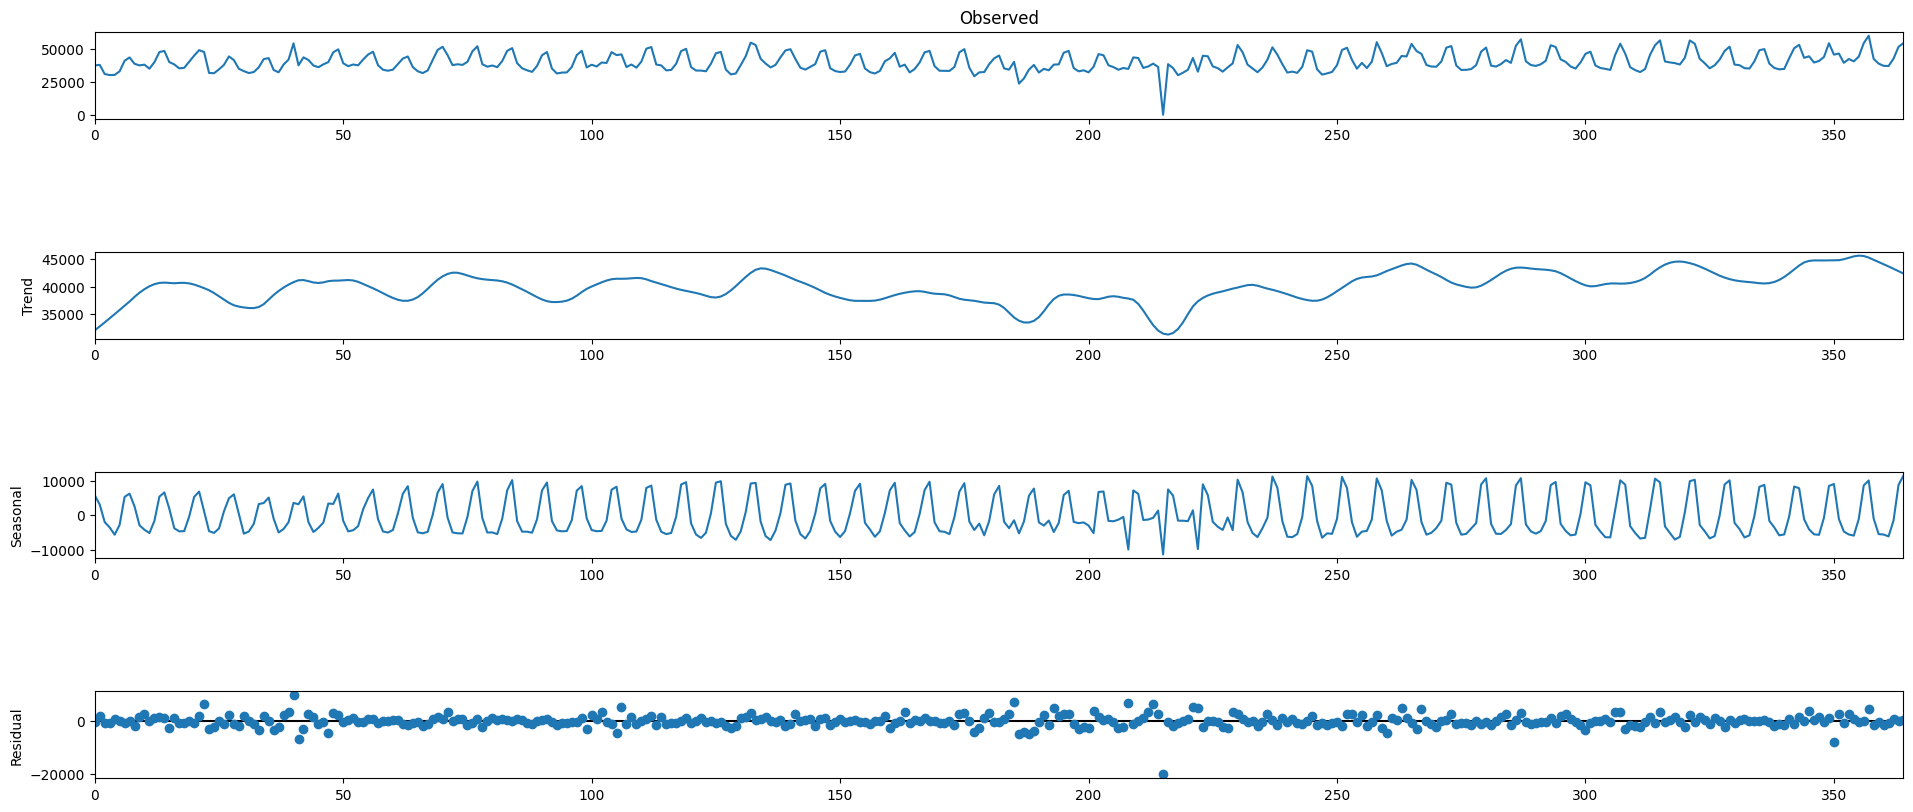

In [107]:
from statsmodels.tsa.seasonal import STL
stl = STL(sales_global[-365:].to_numpy(), period=7)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(20, 10)

# Data preparation

## Select a subset of products

Having this much data is any scientist's dream, but not ideal for quickly iterating over new approaches in what's left of this notebook.

Let's select a subset of the 5 best selling products and stores!

In [108]:
#@title
# compute total sales by summing over all daily sales columns
d_columns = list(raw_sales.filter(regex='d_'))
total_sales = raw_sales[d_columns].sum(axis=1)

# find best selling items
best_selling_items = (
    raw_sales
    .assign(total_sales=total_sales)
    .groupby(ITEM)
    .sum(numeric_only=True)
    .reset_index()
    .sort_values(by="total_sales", ascending=False)
    .iloc[:config["num_items"]][ITEM]
    .tolist()
)
print(f"\n{best_selling_items=}")

# find best selling stores
best_selling_stores = (
    raw_sales
    .assign(total_sales=total_sales)
    .groupby(STORE)
    .sum(numeric_only=True)
    .reset_index()
    .sort_values(by="total_sales", ascending=False)
    .iloc[:config["num_stores"]][STORE]
    .tolist()
)
print(f"\n{best_selling_stores=}")

# select only datapoints that correspond to those items and stores
raw_sales_subset = raw_sales[
    raw_sales[ITEM].isin(best_selling_items) &
    raw_sales[STORE].isin(best_selling_stores)
]

# refresh values present in the ID and ITEM categorical columns
# which now have fewer unique values
raw_sales_subset = raw_sales_subset.assign(
    **{
        ID: raw_sales_subset[ID].astype("object").astype("category"),
        ITEM: raw_sales_subset[ITEM].astype("object").astype("category"),
    }
)

# store selected time series ids in a variable (will be handy later)
ids_subset = raw_sales_subset[ID].unique().tolist()

# same for an example id, item_id and store_id
example_id = raw_sales_subset[ID].unique()[0]
example_store_id = raw_sales_subset[STORE].unique()[0]
example_item_id = raw_sales_subset[ITEM].unique()[0]

print("\nMemory usage:")
print(raw_sales_subset.info())

print("\nRaw sales subset (head):")
raw_sales_subset.head()


best_selling_items=['FOODS_3_090', 'FOODS_3_586', 'FOODS_3_252', 'FOODS_3_555', 'FOODS_3_587']

best_selling_stores=['CA_3', 'CA_1', 'TX_2', 'WI_2', 'WI_3']

Memory usage:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 2314 to 30252
Columns: 1947 entries, id to d_1941
dtypes: category(6), int64(1941)
memory usage: 381.4 KB
None

Raw sales subset (head):


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
2314,FOODS_3_090_CA_1_evaluation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,107,182,47,47,...,77,47,74,38,42,39,51,69,67,64
2476,FOODS_3_252_CA_1_evaluation,FOODS_3_252,FOODS_3,FOODS,CA_1,CA,19,14,10,8,...,38,61,61,36,34,39,30,32,50,50
2779,FOODS_3_555_CA_1_evaluation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,23,16,14,10,...,20,26,25,19,19,26,16,15,32,26
2810,FOODS_3_586_CA_1_evaluation,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,42,36,30,23,...,42,45,71,34,46,33,18,33,48,43
2811,FOODS_3_587_CA_1_evaluation,FOODS_3_587,FOODS_3,FOODS,CA_1,CA,50,121,67,80,...,21,20,29,40,21,24,29,40,39,52


## Melt the raw data

This format where each day is stored in a different column is not suited for the operations we want to do next. Instead, we will convert the dataset such that each `(ID, DAY)` value is stored in a different row. Pandas' [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function does exactly what we need.

<img src="https://drive.google.com/uc?export=view&id=1Tpz0hhBXX6wpIY8ZevgS5sBwBovkbU3n"/>

In [109]:
# Melt (a.k.a. unpivot) `raw_sales_subset` to convert columns [d_1, ..., d_1911] -> columns [d, sales_units]
sales = raw_sales_subset.melt(
    id_vars=[
        ID,
        ITEM,
        DEPT,
        CAT,
        STORE,
        STATE,
    ],
    var_name=DAY,  # column "d" in calendar.csv corresponds with this
    value_name=SALES,
)
# Convert d column to int to be able to operate on it.
sales[DAY] = sales[DAY].str[2:].astype(np.int32)

# Store the sales as int32 to save some memory.
sales[SALES] = sales[SALES].astype(np.int32)

print(sales.info())
sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48525 entries, 0 to 48524
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        48525 non-null  category
 1   item_id   48525 non-null  category
 2   dept_id   48525 non-null  category
 3   cat_id    48525 non-null  category
 4   store_id  48525 non-null  category
 5   state_id  48525 non-null  category
 6   d         48525 non-null  int32   
 7   sales     48525 non-null  int32   
dtypes: category(6), int32(2)
memory usage: 665.5 KB
None


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,FOODS_3_090_CA_1_evaluation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,1,107
1,FOODS_3_252_CA_1_evaluation,FOODS_3_252,FOODS_3,FOODS,CA_1,CA,1,19
2,FOODS_3_555_CA_1_evaluation,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,1,23
3,FOODS_3_586_CA_1_evaluation,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,1,42
4,FOODS_3_587_CA_1_evaluation,FOODS_3_587,FOODS_3,FOODS,CA_1,CA,1,50


Let's quickly verify that all selected items have valid data from the beginning of the time series.

In [110]:
#@title
first_day_by_id = (
    sales
    .groupby(ID)
    .apply(lambda x: (x["sales"] > 0).reset_index(drop=True).idxmax())
    .sort_values(ascending=False)
    .rename("first_day_with_sales")
)

print("First day on which the item was sold:")
first_day_by_id

First day on which the item was sold:


id
FOODS_3_587_WI_2_evaluation    3
FOODS_3_587_CA_3_evaluation    3
FOODS_3_090_CA_1_evaluation    0
FOODS_3_555_WI_2_evaluation    0
FOODS_3_587_TX_2_evaluation    0
FOODS_3_587_CA_1_evaluation    0
FOODS_3_586_WI_3_evaluation    0
FOODS_3_586_WI_2_evaluation    0
FOODS_3_586_TX_2_evaluation    0
FOODS_3_586_CA_3_evaluation    0
FOODS_3_586_CA_1_evaluation    0
FOODS_3_555_WI_3_evaluation    0
FOODS_3_555_TX_2_evaluation    0
FOODS_3_090_CA_3_evaluation    0
FOODS_3_555_CA_3_evaluation    0
FOODS_3_555_CA_1_evaluation    0
FOODS_3_252_WI_3_evaluation    0
FOODS_3_252_WI_2_evaluation    0
FOODS_3_252_TX_2_evaluation    0
FOODS_3_252_CA_3_evaluation    0
FOODS_3_252_CA_1_evaluation    0
FOODS_3_090_WI_3_evaluation    0
FOODS_3_090_WI_2_evaluation    0
FOODS_3_090_TX_2_evaluation    0
FOODS_3_587_WI_3_evaluation    0
Name: first_day_with_sales, dtype: int64

# Model evaluation

Now that our dataset is ready, lets define how we'll be evaluating the different models we'll train.

## Evaluation metric

We'll need to pick a metric that allows us to easily evaluate a model's performance on the unseen test data.

One of the most commonly used metrics for regression problems (i.e. predicting a numerical value) is the **Root Mean Squared Error**, which is computed as the root of the averaged squared error of the model on each datapoint:

$R M S E=\sqrt{\frac{1}{n} \sum_{t=1}^{n}\left(y_t-\hat{y}_t\right)^2}$


However, the M5 competition opted for a more complex one called **Root Mean Squared *Scaled* Error** that we will be using as our evaluation  metric, defined as:

$R M S S E=\sqrt{\frac{\frac{1}{h} \sum_{t=n+1}^{n+h}\left(y_t-\hat{y}_t\right)^2}{\frac{1}{n-1} \sum_{t=2}^n\left(y_t-y_{t-1}\right)^2}}$

where $y_t$ is the actual future value of the examined time series at point $t$, $\hat{y}_t$ the generated forecast at that point, $n$ the length of the training sample (number of historical observations), and $h$ the forecasting horizon.

The additional scaling term scales the squared error by the error that would come from the _naive forecast_, i.e. always using the last datapoint as the prediction for the next one.

The guidelines in the [M5 participants guide](https://mofc.unic.ac.cy/m5-competition/) goes into detail as to why this is a better metric for this scenario, such as it being scale independent (and thus allowing comparing forecasts across series with different scales) and penalizing positive and negative errors in large and small forecasts equally.

In [111]:
def RMSSE(
    historical: np.ndarray,
    forecast: np.ndarray,
    actual: np.ndarray
) -> float:
    """Calculate the RMSSE over a generated forecast for horizon h for a time
    series of length n = len(historical).

    Params:
        historical: the historical observations of the series, of shape (n,).
        forecast: the generated forecast for horizon h of the series, of shape
            (h,).
        actual: the true future values in horizon h of the series, of same shape
            as `forecast`.
    """
    n = len(historical)
    h = len(forecast)

    numerator = np.sum(np.square(forecast - actual))

    denominator = np.sum(np.square((historical[1:] - historical[:-1]))) / (n - 1)

    return np.sqrt((1 / h) * (numerator / denominator))

In [112]:
def mean_RMSSE(df_preds: pd.DataFrame) -> float:
    """Calculate the average RMSSE over the forecasted values of a set of
    independent time series.

    Params:
        df_preds: a DataFrame containing the forecasted values. Each row
            contains the forecasted value for a certain ID and DAY.
    """
    time_series_ids = df_preds[ID].unique()
    n_time_series = len(time_series_ids)

    # merge forecasts with ground truth labels
    df_true_pred = df_preds.merge(sales_test, on=[ID, DAY])

    rmsses = 0
    for time_series_id in time_series_ids:
        # train data
        historical = (
            sales_train[sales_train[ID] == time_series_id][SALES].to_numpy()
        )
        # model predictions
        forecast = (
            df_true_pred[df_true_pred[ID] == time_series_id][PRED].to_numpy()
        )
        # ground truth values
        actual = (
            df_true_pred[df_true_pred[ID] == time_series_id][SALES].to_numpy()
        )
        # calculate RMSSE
        rmsses += RMSSE(historical, forecast, actual)

    return rmsses / n_time_series

## Test set

We'll be using the last `num_horizons` (which corresponds to `7` in the `MINI` execution mode) days of data as our test set.

**During the M5 competition, the last 28 days were used as the validation set for the public leaderboard.**

Let's compute the train cut-off day, and how many datapoints we have for training and testing.

In [113]:
#@title
last_day = sales[DAY].max()
train_cutoff_day = last_day - config["num_horizons"]

mask_train = sales[DAY] <= train_cutoff_day
mask_test = ~mask_train

sales_train = sales[mask_train]
sales_test = sales[mask_test]

print(f"{train_cutoff_day=}")
print(f"Number of training examples: {sum(mask_train)}")
print(f"Number of testing examples: {sum(mask_test)}")

train_cutoff_day=1934
Number of training examples: 48350
Number of testing examples: 175


# Time to forecast!

Now that we have our trimmed raw dataset ready and have defined how we'll be evaluating our forecasts, it's time to start iterating on our forecasting method.

We'll try three different methods:
- As a **baseline**, we'll compute the **average sales of the last 28 days** for each ID, and use those static values as our prediction for the whole horizon. Note that this is a very naive, simple and fast method, which makes it good for a baseline but not anything else.
- To improve on our baseline, we'll fit a classical statistical model, **SARIMA**, to the raw sales values of each time series.
- Finally, we'll train a **Gradient Boosted Decision Trees** model, or GBDT, and iteratively add new features to it and measure their impact on performance.

# Baseline forecast

For a baseline we will use the **average of the last 28 datapoints for each id** in our training data.

### Exercise

In [114]:
# def compute_average_per_id(sales_train: pd.DataFrame, window_length:int = 28):
#   """ Compute the average of the last `window_lenght` datapoints for each `ID`. """

#   # TODO: add your code #

#   return average_per_id

In [115]:
#@title Solution
def compute_average_per_id(sales_train: pd.DataFrame, window_length:int = 28):
  """ Compute the average of the last `window_lenght` datapoints for each `ID`. """

  average_per_id = (
    sales_train
    .groupby(ID)
    .apply(lambda ts: ts.iloc[-window_length:][SALES].mean())
    .rename(PRED)
  )

  return average_per_id

In [116]:
average_per_id = compute_average_per_id(sales_train)

print(average_per_id[:5])

id
FOODS_3_090_CA_1_evaluation     59.392857
FOODS_3_090_CA_3_evaluation    123.142857
FOODS_3_090_TX_2_evaluation     63.750000
FOODS_3_090_WI_2_evaluation     21.357143
FOODS_3_090_WI_3_evaluation     77.535714
Name: sales_pred, dtype: float64


In [117]:
# merge the computed averages per id with each row corresponding to that id
df_preds_baseline = sales_test.merge(
    average_per_id,
    on=ID,
    how="left"
)[[ID, DAY, PRED]]

df_preds_baseline.head()

,id,d,sales_pred
0,FOODS_3_090_CA_1_evaluation,1935,59.392857
1,FOODS_3_252_CA_1_evaluation,1935,38.321429
2,FOODS_3_555_CA_1_evaluation,1935,19.500000
3,FOODS_3_586_CA_1_evaluation,1935,41.714286
4,FOODS_3_587_CA_1_evaluation,1935,18.428571


In [118]:
#@title Definition of  `plot_predictions` and `plot_hbar_metrics`

def plot_predictions(
    df_preds: pd.DataFrame,
    ids: Union[List[str], int]=3,
    n_historical_days: int=28,
    figsize: Tuple[int, int]=(12, 8)
) -> None:
    if type(ids) is int:
        # take first ids
        ids = df_preds[ID].unique()[:ids]
    n_ids = len(ids)

    # merge forecasts with ground truth labels
    df_true_pred = df_preds.merge(sales_test, on=[ID, DAY])

    # create figure
    fig, axes = plt.subplots(n_ids, 1, figsize=figsize)

    # plot
    for i, id_ in enumerate(ids):
        # ground truth
        sns.lineplot(
            data=df_true_pred[df_true_pred[ID] == id_],
            x=DAY,
            y=SALES,
            ax=axes[i],
            marker="o",
            markersize=5,
            label="ground truth"
        )
        # forecast
        sns.lineplot(
            data=df_true_pred[df_true_pred[ID] == id_],
            x=DAY,
            y=PRED,
            ax=axes[i],
            marker="o",
            markersize=5,
            label="forecast"
        )
        # historical
        sns.lineplot(
            data=sales_train[sales_train[ID] == id_][-n_historical_days:],
            x=DAY,
            y=SALES,
            ax=axes[i],
            marker="o",
            markersize=5,
            label="historical"
        )
        axes[i].set_xlabel(None)
        axes[i].set_title(id_)
        axes[i].legend(loc="upper left")

    axes[i].set_xlabel("day")
    plt.subplots_adjust(hspace=0.35)


def plot_hbar_metrics(
    results: str,
    metric_name: str="RMSSE",
    figsize: Tuple[int, int]=(6, 10)
) -> None:
  ax = (
      pd.Series(results)
      .sort_values()
      .to_frame(metric_name)
      .plot
      .barh(title="Collected Metrics")
  )
  for container in ax.containers:
    ax.bar_label(container)

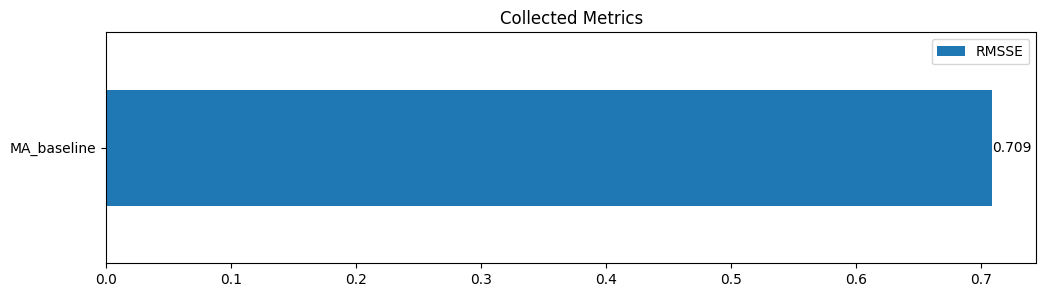

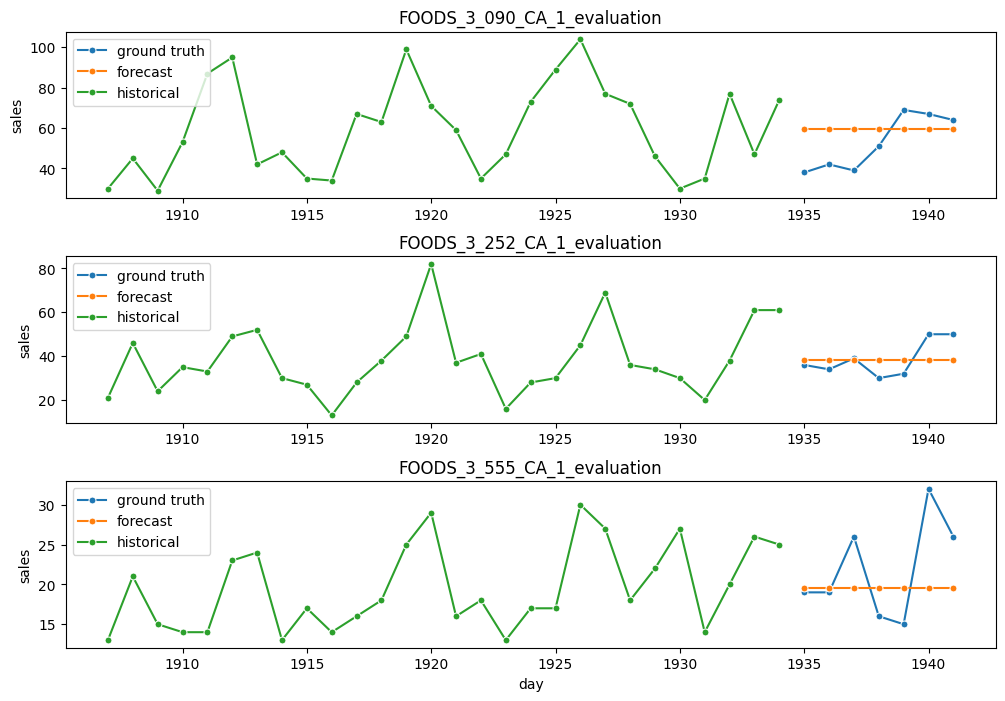

In [119]:
results = {}
results["MA_baseline"] = round(mean_RMSSE(df_preds_baseline), 3)
plot_hbar_metrics(results)

plot_predictions(df_preds_baseline)

As expected, the predictions form a straight line over the forecasting horizon, that goes straight through the middle of the true values. This is a great starting point to put the other methods up against!

# SARIMA

SARIMA is a forecasting method for univariate time series data, and can be understood by dividing it into each of its components:

- **Autoregressive (AR)**: forecast using a linear combination of past values of our target variable. `p` denotes the number of autoregressive terms, or number of lags to be taken into account.
- **Moving Average (MA)**: forecast using a linear combination of past forecast errors. `q` denotes the number of moving average terms.
- **Integrated (I)**: forecast by differencing past values of our target variable to allow for modelling of non-stationary time series. `d` denotes the differencing order to be used.
- **Seasonal (S)**: includes an explicit seasonal component to the model, which consists of terms similar to the ones described above but computed on backshifts of the seasonal period. `P`, `D` and `Q` denote the `p`, `d` and `q` of the seasonal component, and `s` the seasonal length in the data.

For this experiment, we chose the following parameter values:
- `p`, `q`, `P` and `Q` = `1`, since it yields the simplest form of the model, and higher values didn't significantly improve performance and made the model slower to fit.
- `d` and `D` = `1`, since in our analysis we noticed a linear trend in the data, and the first order difference should be enough to allow our model to capture it.
- `s` = `7`, since our data's strongest seasonal cycle is the weekly one.

It is worth noting that **searching for the correct values for these hyperparameters is generally done manually via several trials and analysis of (partial) autocorrelation plots**, which is off scope for this codecamp. Another option is to use a package such as [autoarima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) to automatically find the set of parameters that best fits the data.

SARIMA shines in its simplicity and interpretability, but can quickly become very slow to fit if the values of `p` and `q` are high.

SARIMA also cannot benefit from cross-learning from several series, which we'll explain below, and unlike its cousin SARIMA-X, fails to be able to incorporate exogenous data as explanatory variables.

<font color="red"> Note: Run cells before expanding them.

In [120]:
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 7

df_preds_sarima = pd.DataFrame(
    {
        ID: np.repeat(ids_subset, config["num_horizons"]),
        DAY: sales_test[DAY].unique().tolist() * len(ids_subset),
        PRED: [None] * len(ids_subset) * config["num_horizons"]
    },
).set_index(ID)

for id_ in tqdm(ids_subset):
    # select training time series
    train_ts = (
        sales_train[sales_train[ID] == id_][SALES].to_numpy()
    )
    # instance SARIMA model
    model = ARIMA(
        endog=train_ts,
        order=(p, d, q),
        seasonal_order=(P, D, Q, s)
    )
    # fit model
    model = model.fit()

    # predict
    pred = model.forecast(steps=config["num_horizons"])

    # store predictions
    df_preds_sarima.loc[id_, PRED] = pred

df_preds_sarima = df_preds_sarima.reset_index()

100%|██████████| 25/25 [00:48<00:00,  1.95s/it]


In [121]:
df_preds_sarima

,id,d,sales_pred
0,FOODS_3_090_CA_1_evaluation,1935,48.584781
1,FOODS_3_090_CA_1_evaluation,1936,41.565376
2,FOODS_3_090_CA_1_evaluation,1937,40.678001
3,FOODS_3_090_CA_1_evaluation,1938,43.631049
4,FOODS_3_090_CA_1_evaluation,1939,66.589767
...,...,...,...
170,FOODS_3_587_WI_3_evaluation,1937,21.165967
171,FOODS_3_587_WI_3_evaluation,1938,18.386902
172,FOODS_3_587_WI_3_evaluation,1939,21.765687
173,FOODS_3_587_WI_3_evaluation,1940,25.454138


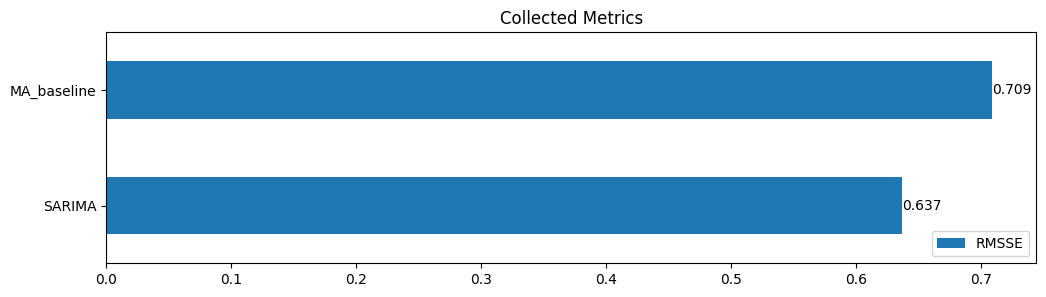

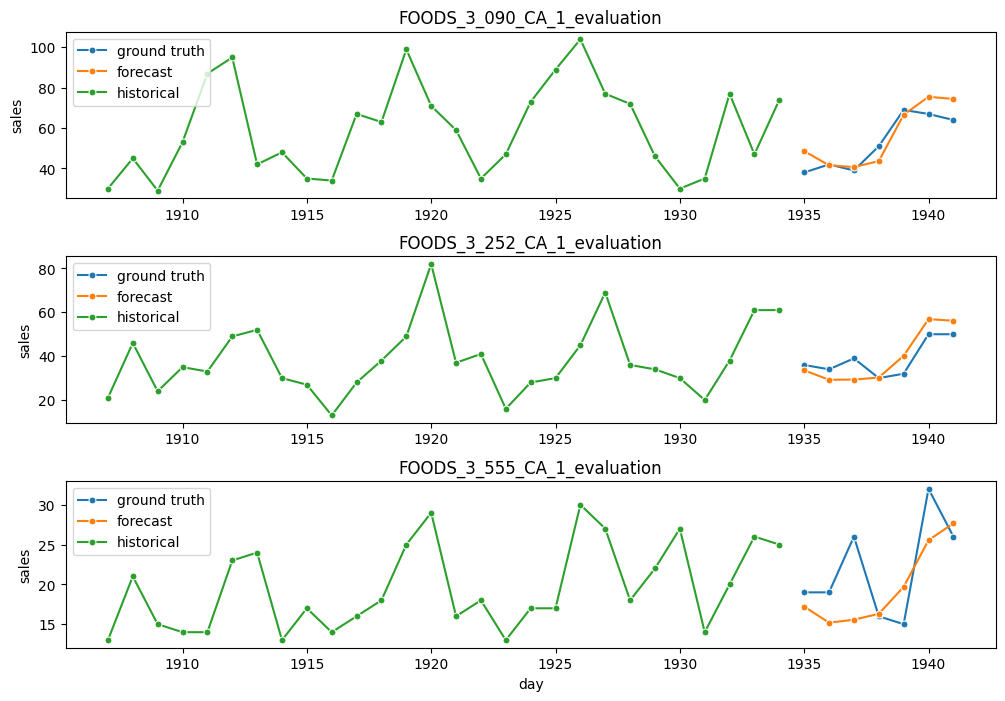

In [122]:
results["SARIMA"] = round(mean_RMSSE(df_preds_sarima), 3)
plot_hbar_metrics(results)

plot_predictions(df_preds_sarima)

# Forecasting using a tabular ML algorithm: Decision Forests

## Introduction

In the previous section, we used a statistical model to forecast the future sales from the past ones. Although such models can work well in practice, their **power of expression is limited**: notably, SARIMA applies on a single time series, and the relation between the input features and the label is linear.

In this section, we will learn to use a more powerful method by **converting the time series into a single tabular dataset** and using an **off-the-shelf** machine learning algorithm to forecast.

<font color="red"> Note: Collapse this section and run cells before continuing.

In [123]:
#@title

import pydot
from IPython.display import Image

dot_string = """graph {
rankdir="LR";
node [shape="box"];
edge [dir=forward];

a -> b [label="convert"];
b -> c [label="train"];
c -> d [label="predict"];

a [label="Time series"];
b [label="Tabular dataset"];
c [label="Off-the-shelf tabular model"];
d [label="Forecast"];
}"""

graphs = pydot.graph_from_dot_data(dot_string)
graphs[0].write_png("output.png")
Image("output.png")

FileNotFoundError: [WinError 2] "dot" not found in path.

In this particular example, we will use Gradient Boosted Decision Trees (GBDTs) models as they are easy to use and well suited for tabular datasets.

Unlike SARIMA, we will be training a single model for all the existing IDs, instead of one for each, since GBDTs benefit from large datasets, and training a single one also allows for cross-learning, which means the model being able to learn and use patterns from multiple time series at the same time.

We won't explain how Gradient Boosted Trees work here. If you want to learn more about GBDTs and other decision forest models, [Google's Decision Forests class](https://developers.google.com/machine-learning/decision-forests) is a good resource.

The techniques we show in this section can also be used with any other ML model for tabular data. For example, one can use a random forest, an SVM, a nearest neighbors model, or a feed-forward neural network.

## Minimal GBDT crash course

In the context of temporal modeling, there are some things to know about GBDTs:

1. GBDTs are a collection of small decision trees. The prediction of the model is the sum of the predictions of the individual trees. The way GBDTs are trained makes that the first trees are the most important for the predictions.

2. GBDTs work well with default settings. Hyper-parameter tuning can improve the model quality, but will not be covered in this tutorial.

3. GBDTs can natively consume numerical and categorical features. It is *not* a good idea to use one-hot encoding for categorical features in GBDTs.

4. GBDTs are **not able to extrapolate** values, that is, the model is only able to predict within the range of already seen values. For example, if the labels of the training examples are between 0 and 100, the GBDT is unlikely to make predictions outside of this range. If we suspect our dataset needs extrapolation patterns and we want to use a GBDT, we would need to pre-process our labels (e.g. using an STL model first). Note that such label pre-processing can also be beneficial even if the model does not need to extrapolate. We will not cover extrapolation in this tutorial.

## Features

We want to manually create tabular features that correspond to the temporal patterns we think are discriminant for our data. In this section, we will start with a simple option: feeding each series' last 28 values to the model.

In the next sections, we show more advanced feature engineering and how to feed other signals into the model.

## Labels

Our objective is to forecast the sales for the next 7 days. There are two common solutions to make such labels:

1. With **direct method**, we train a separate model for each of the 7 days. For example, the first model predicts the next day's sales, the second model predicts the sales two days in the future, and the last model predicts the sales 7 days from now.

2. With the **recursive method**, we train a single model to predict the next day's sales. This model is applied iteratively using its predictions as input features for its next prediction.

<img src="https://drive.google.com/uc?export=view&id=1A7sdEKc1BTPD1mPQHt3SRVWTUCIJJtm2" height=400/>

In this tutorial, we focus on the direct method. Know that both methods are valid, and the one that will work best depends on the dataset.

*Trivia*: The method that won the M5 competitions was composed of an ensemble of direct and recursive GBDTs.


**Question:** What are three fundamental differences between the recursive and direct method.

In [ ]:
#@title Solution

# 1. Training a separate model for each horizon for the direct approach takes longer than training a single model for the recursive approach.
# 2. In the recursive approach, the model needs to be applied multiple times in sequence, while in the direct approach, models can be applied in parallel.
# 3. In the recursive approach, the error made at one step propagates and is possible piles-up in the next steps.
# 4. In the direct approach, the predictions for different horizons are generated independently and are possibly not correlated.

## Labels: The next h days of sales

The label with horizon $h$ at time $t$ is the sales value at time $t+h$. In other words, the label *shifts* the data from the future to the past.

In [ ]:
def create_labels(
    ds: pd.DataFrame,
    predict_horizon: int=config["num_horizons"]
) -> pd.DataFrame:
  """Extract tabular labels for the next `predict_horizon` steps.

  Returns a dataframe with the extracted label, the label keys, and the
  horizons.
  """

  ds = ds.copy()
  grouped_sales = ds.groupby([STORE, ITEM])[SALES]
  keys = []
  horizons = list(range(1, predict_horizon + 1))

  for h in horizons:
    key = f"label_h_{h}"
    ds[key] = grouped_sales.transform(lambda item: item.shift(-h))
    keys.append(key)

  return ds, keys, horizons

Lets visualize this shift:

C:\Users\andre\AppData\Local\Temp\ipykernel_19448\1953539202.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


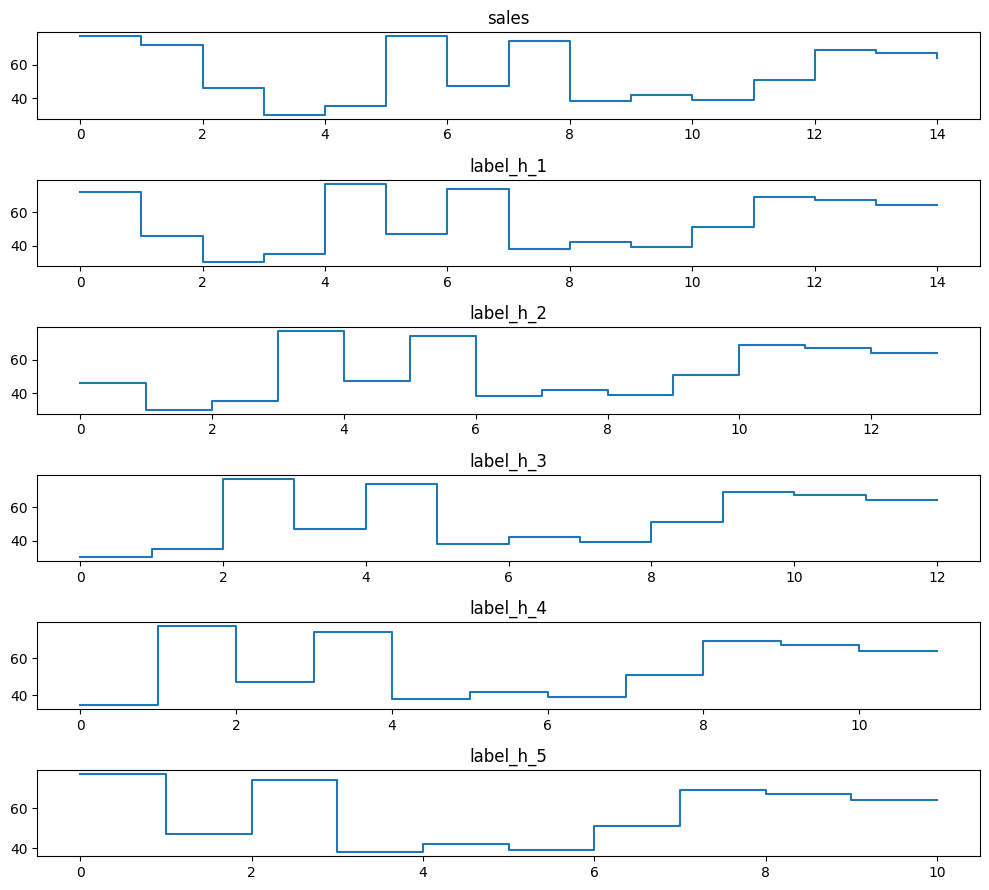

In [ ]:
def plot_tabular_features(dataset: pd.DataFrame, column_names:List[str], num_steps:int=28, subfig_height:float=1.5):
  """Plot tabular features / labels."""

  # Select only the selected item+store
  dataset = dataset[dataset[ID] == example_id]

  # Select the last "num_steps" days.
  if num_steps is not None:
    dataset = dataset[dataset.d >= last_day - num_steps]

  fig, axes = plt.subplots(nrows=len(column_names), ncols=1, figsize=(10,subfig_height*len(column_names)))
  for column_idx, column_name in enumerate(column_names):
    values = dataset[column_name]
    axes[column_idx].step(list(range(len(values))),values, where="post")
    axes[column_idx].set_title(column_name)
  fig.tight_layout()
  fig.show()

# Generate the labels
dataset, label_keys, _ = create_labels(sales, predict_horizon=5)

# Plot the labels
plot_tabular_features(dataset, [SALES] + label_keys, num_steps=14)

**Question:** Can you see the "shift" of the label when h increases? What would a shift in the other direction mean?

## Features: The last 28 days of sales

Computing the last 28 days of sales is similar to computing the labels, except that the shift is in the opposite direction.

In [ ]:
def create_feature_lag_sales(
    ds: pd.DataFrame,
    num_steps: int=28
) -> pd.DataFrame:
  """Extract the last `num_steps` sales as tabular features.

  Returns the updated dataframe and the feature keys.

  Increasing the value of num_steps could increase the quality of the results,
  but also increase the training time.
  """

  ds = ds.copy()
  grouped_sales = ds.groupby([STORE, ITEM])[SALES]
  keys = []

  for h in range(0, num_steps):
    key = f"lag_{h}.sales"
    # TODO: add you code here #
    keys.append(key)

  return ds, keys

In [ ]:
#@title Solution
def create_feature_lag_sales(
    ds: pd.DataFrame,
    num_steps: int=28
) -> pd.DataFrame:
  """Extract the last `num_steps` sales as tabular features.

  Returns the updated dataframe and the feature keys.

  Increasing the value of num_steps could increase the quality of the results,
  but also increase the training time.
  """

  ds = ds.copy()
  grouped_sales = ds.groupby([STORE, ITEM])[SALES]
  keys = []

  for h in range(0, num_steps):
    key = f"lag_{h}.sales"
    ds[key] = grouped_sales.transform(lambda item: item.shift(h))
    keys.append(key)

  return ds, keys

## Assemble the tabular datasets

*Remember: Days 1-1913 are used for the training dataset, days 1914-1941 are used for the testing dataset.*

The number of tabular training examples is different for each horizon.

**Details:** For example, day 1913 (the last day in the training dataset) is the label for the training tabular example with horizon 1 on day 1912. But day 1913 is also the label for the training tabular example with horizon 2 on day 1911, etc.
However, there is no training dataset for model training with horizion 2 on day 1913 (since this would require it to use the values of day 1914 which is not part of the training dataset).


For similar reasons, lagging features are not available for the steps of the training dataset. For instance, lagging of 3 is not available on days 1-3.


The following functions `get_tab_test_dataset` and `get_tab_train_dataset` extract valid training and testing tabular datasets.

In [ ]:
# Split the dataset into training and testing
def get_tab_test_dataset(dataset_with_labels: pd.DataFrame):
  """Build the testing dataset."""

  # The test only contain one row for each example. This row correspond to the
  # last day of training (day=1913), and predicts the next 28 days (1914-1941).
  mask = dataset_with_labels[DAY] == train_cutoff_day
  return dataset_with_labels[mask]

def get_tab_train_dataset(
    dataset_with_labels: pd.DataFrame,
    horizon: int,
    skip_days: int=28
) -> pd.DataFrame:
  "Build the training dataset"

  assert horizon > 0

  # We skip the first "skip_days" of training a there are not enough historical
  # data to compute the lags reliably.

  # Make sure we don't use test examples.
  last_day = train_cutoff_day - horizon
  mask = (
      (dataset_with_labels[DAY] >= skip_days) &
      (dataset_with_labels[DAY] <= last_day)
  )
  return dataset_with_labels[mask]

In [ ]:
# Build the label and features.
dataset = sales
dataset, label_keys, label_horizons = create_labels(dataset)
dataset, feature_lag_sales_keys = create_feature_lag_sales(dataset)

# Collect the signals
#
# Note: Later, we will add all the meta data (e.g. stage, store id,
# item category) at input feature to the model.
meta_columns = [STORE, ITEM]
feature_names = feature_lag_sales_keys + meta_columns
dataset = dataset[feature_names + label_keys + [ID, DAY]]

get_tab_test_dataset(dataset).head()

,lag_0.sales,lag_1.sales,lag_2.sales,lag_3.sales,lag_4.sales,lag_5.sales,lag_6.sales,lag_7.sales,lag_8.sales,lag_9.sales,...,item_id,label_h_1,label_h_2,label_h_3,label_h_4,label_h_5,label_h_6,label_h_7,id,d
48325,74,47.0,77.0,35.0,30.0,46.0,72.0,77.0,104.0,89.0,...,FOODS_3_090,38.0,42.0,39.0,51.0,69.0,67.0,64.0,FOODS_3_090_CA_1_evaluation,1934
48326,61,61.0,38.0,20.0,30.0,34.0,36.0,69.0,45.0,30.0,...,FOODS_3_252,36.0,34.0,39.0,30.0,32.0,50.0,50.0,FOODS_3_252_CA_1_evaluation,1934
48327,25,26.0,20.0,14.0,27.0,22.0,18.0,27.0,30.0,17.0,...,FOODS_3_555,19.0,19.0,26.0,16.0,15.0,32.0,26.0,FOODS_3_555_CA_1_evaluation,1934
48328,71,45.0,42.0,44.0,34.0,41.0,48.0,61.0,52.0,43.0,...,FOODS_3_586,34.0,46.0,33.0,18.0,33.0,48.0,43.0,FOODS_3_586_CA_1_evaluation,1934
48329,29,20.0,21.0,12.0,21.0,10.0,23.0,21.0,25.0,14.0,...,FOODS_3_587,40.0,21.0,24.0,29.0,40.0,39.0,52.0,FOODS_3_587_CA_1_evaluation,1934


## Train GBDT

Let's train GBDTs for each of the horizons. We are using the [Tensorflow Decision Forests library](https://www.tensorflow.org/decision_forests/) to train the trees.

**Note:** For the sake of training quickly, the GBDTs will be trained with only a few trees (10 or 50). To get reasonable results, GBDTs should be trained on much more trees (e.g. 500).

**Note:** Make sure to run training cells before diving into the explanation.

In [ ]:
# class DirectGBDTResult(NamedTuple):
#   """Result of the "train_direct_gbt_models" function."""

#   # Number of trees
#   num_trees: int

#   # Features the model was trained on
#   feature_names: List[str]

#   # Models for each horizon
#   models: List[tfdf.keras.GradientBoostedTreesModel]

#   # RMSE of the model for each horizon computed on the validation data
#   self_evaluation: List[float]

#   # Dictionary mapping time series ids to next-horizon forecasts
#   predictions: Dict[str, np.array]

In [ ]:
# def train_direct_gbt_models(
#     dataset: pd.DataFrame,
#     feature_names: List[str],
#     num_trees: int=config["num_trees"],
#     num_horizons: int=config["num_horizons"],
#     verbose: int=0,
# ) -> DirectGBDTResult:
#   """Trains a GB(D)T model for each of the horizons.

#   Args:
#     dataset: Tabular dataset containing training and test examples..
#     feature_names: Input features of the model.

#   Returns:
#     The predictions for each item and each horizon, the models, and the
#     self-model evaluation.
#   """
#   # Extract the test dataset
#   #
#   # Note: The test dataset contains a single day.
#   test_tab_ds = get_tab_test_dataset(dataset)

#   # Predictions of each model on each ID.
#   predictions = []

#   # Model self evaluation (RMSE) for each of the horizons.
#   self_evaluation = []

#   # The GBT models.
#   models = []

#   for horizon in range(1, num_horizons + 1):

#     # Extract the train dataset for this horizon
#     train_tab_ds = get_tab_train_dataset(dataset, horizon=horizon)

#     # Convert dataset from Pandas to TensorFlow format
#     label_key = f"label_h_{horizon}"
#     train_ds_tf = tfdf.keras.pd_dataframe_to_tf_dataset(
#         train_tab_ds,
#         label=label_key,
#         task=tfdf.keras.Task.REGRESSION
#     )
#     test_ds_tf = tfdf.keras.pd_dataframe_to_tf_dataset(
#         test_tab_ds,
#         label=label_key,
#         task=tfdf.keras.Task.REGRESSION
#     )

#     # Train a GBT
#     print(
#         f"Training model for horizon={horizon} |"
#         f" {len(train_tab_ds)} training examples |"
#         f" {len(test_tab_ds)} test examples"
#     )
#     model = tfdf.keras.GradientBoostedTreesModel(
#         # Only use those features.
#         features=[tfdf.keras.FeatureUsage(feat) for feat in feature_names],
#         exclude_non_specified_features=True,
#         num_trees=num_trees,
#         # This is a regression task.
#         task=tfdf.keras.Task.REGRESSION,
#         # Control the amount of training logs.
#         verbose=verbose,
#     )
#     model.fit(train_ds_tf)
#     models.append(model)

#     # Extract the model self-evaluation. In this case, the self evaluation if
#     # the validatin RMSE.
#     self_evaluation.append(model.make_inspector().evaluation().rmse)

#     # Generate prediction on test dataset.
#     predictions.append(model.predict(test_ds_tf, verbose=0).flatten())

#   # Format predictions to be compatible with the "plot_predictions" function.
#   stacked_predictions = {
#       test_tab_ds.iloc[i][ID]: predictions
#       for i, predictions in enumerate(np.array(predictions).T)
#   }
#   return DirectGBDTResult(
#       num_trees=num_trees,
#       feature_names=feature_names,
#       predictions=stacked_predictions,
#       self_evaluation=self_evaluation,
#       models=models,
#   )

In [ ]:
# %%time
# gbdt_result = train_direct_gbt_models(
#     dataset=dataset,
#     feature_names=feature_names,
# )

## Model self-evaluation

In the cell above, we did not provide a validation dataset. Therefore, the model automatically extracted 10% of the training dataset for validation. The next plots show

1. The validation RMSE of the 7 models according to their forecast horizon, and
2. The validation RMSE according to the number of trees for the h=7 model.